In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# load dataset
dataset=pd.read_csv('./diabetes.csv')
dataset.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [3]:
# Overview of Dataset Characteristics
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
#Summary of N/A Values
dataset.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
#Distribution of Classes
dataset.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [6]:
#Review Correlation between Variables
dataset.corr()

Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.129459       0.141282      -0.081672   
Glucose                      0.129459  1.000000       0.152590       0.057328   
BloodPressure                0.141282  0.152590       1.000000       0.207371   
SkinThickness               -0.081672  0.057328       0.207371       1.000000   
Insulin                     -0.073535  0.331357       0.088933       0.436783   
BMI                          0.017683  0.221071       0.281805       0.392573   
DiabetesPedigreeFunction    -0.033523  0.137337       0.041265       0.183928   
Age                          0.544341  0.263514       0.239528      -0.113970   
Outcome                      0.221898  0.466581       0.065068       0.074752   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.073535  0.017683                 -0.033523   
Glucose                   0.331357  0.221071                  0.137337   
BloodPressure             0.088933  0.281805                  0.041265   
SkinThickness             0.436783  0.392573                  0.183928   
Insulin                   1.000000  0.197859                  0.185071   
BMI                       0.197859  1.000000                  0.140647   
DiabetesPedigreeFunction  0.185071  0.140647                  1.000000   
Age                      -0.042163  0.036242                  0.033561   
Outcome                   0.130548  0.292695                  0.173844   

                               Age   Outcome  
Pregnancies               0.544341  0.221898  
Glucose                   0.263514  0.466581  
BloodPressure             0.239528  0.065068  
SkinThickness            -0.113970  0.074752  
Insulin                  -0.042163  0.130548  
BMI                       0.036242  0.292695  
DiabetesPedigreeFunction  0.033561  0.173844  
Age                       1.000000  0.238356  
Outcome                   0.238356  1.000000

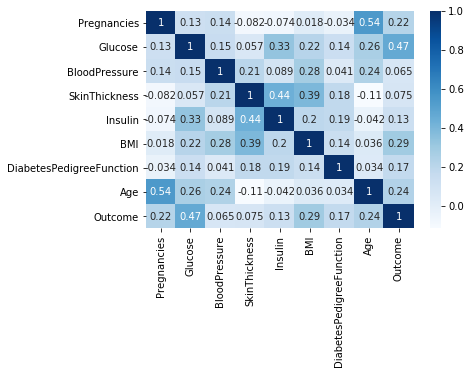

In [7]:
#Visualiztion of Correlations
import seaborn as sns
sns.heatmap(dataset.corr(),annot=True,cmap="Blues")

In [8]:
#Create x and y variables
x = dataset.drop('Outcome', axis=1).values
Y = dataset['Outcome'].values

In [9]:
#Prepare for Models for Comparison

#Load Library for Training
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

#Fix the imbalanced Classes
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_resample(x_train,y_train)

#Import Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [10]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pipe_lda = Pipeline([('scl', StandardScaler()),
                    ('clf', LinearDiscriminantAnalysis())])

pipe_qda = Pipeline([('scl', StandardScaler()),
                    ('clf', QuadraticDiscriminantAnalysis())])

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(random_state=100))])

# Set grid search params 

param_gridlda = {'clf__solver':['svd','lsqr','eigen']}

param_gridqda = {}

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l1', 'l2']}

#Optimize Models

opt_lda = GridSearchCV(estimator=pipe_lda, param_grid=param_gridlda,
                       cv=10, verbose=0,scoring='accuracy',n_jobs=-1)

opt_qda = GridSearchCV(estimator=pipe_qda, param_grid=param_gridqda,
                       cv=10, verbose=0,scoring='accuracy',n_jobs=-1)

opt_logreg = GridSearchCV(estimator=pipe_logreg, param_grid=param_gridlogreg,
                       cv=10, verbose=0,scoring='accuracy',n_jobs=-1)

# List of pipelines for ease of iteration 
grids = [opt_lda,opt_qda,opt_logreg] 

# Dictionary of pipelines and classifier types for ease of reference 
grid_dict = {0:'lda',1: 'qda',2:'LR'}

In [11]:
#create table to compare MLA metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score
pd.set_option('display.max_colwidth', -1) 
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for idx, gs in enumerate(grids):
    
    #Fit grid search
    gs.fit(x_train_smt, y_train_smt)
    
    # Predict on test data with best params 
    y_pred2 = gs.predict(x_test)     
    
    #Create Dataframe to Compare Models
    MLA_compare.loc[row_index,'Algorithm Name'] = grid_dict[idx]
    MLA_compare.loc[row_index,'Train Accuracy'] = round(gs.best_score_, 2)
    MLA_compare.loc[row_index,'Precision'] = round(precision_score(y_test, y_pred2,average='weighted'),2)
    MLA_compare.loc[row_index,'Recall'] = round(recall_score(y_test, y_pred2,average='weighted'),2)
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(gs.best_params_)
    row_index+=1
    
MLA_compare.sort_values(by = ['Precision'], ascending = False, inplace = True)    
MLA_compare

C:\Users\100274743\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Algorithm Name  Train Accuracy  Precision  Recall  \
1  qda            0.71            0.79       0.79     
0  lda            0.74            0.77       0.76     
2  LR             0.75            0.75       0.74     

                          MLA Parameters  
1  {}                                     
0  {'clf__solver': 'svd'}                 
2  {'clf__C': 0.1, 'clf__penalty': 'l2'}

In [12]:
#Prediction Dataset
                   
raw_data = {'Pregnancies':[1],'Glucose':[80],'BloodPressure':[65],'SkinThickness':[35],'Insulin':[80],
            'BMI':[24],'DiabetesPedigreeFunction':[0.200],'Age':[30]}

dfnew=pd.DataFrame(raw_data, columns = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin',
                                        'BMI','DiabetesPedigreeFunction','Age'])

dfnew

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  \
0  1            80       65             35             80       24    

   DiabetesPedigreeFunction  Age  
0  0.2                       30

In [13]:
#Prediction
print('Predicted Outcome - LogReg:',opt_lda.predict(dfnew))
print('Predicted Outcome - LogReg:',opt_qda.predict(dfnew))
print('Predicted Outcome - LogReg:',opt_logreg.predict(dfnew))

Predicted Outcome - LogReg: [0]
Predicted Outcome - LogReg: [0]
Predicted Outcome - LogReg: [0]


C:\Users\100274743\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\100274743\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\100274743\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
